# House Price Prediction - Fixed Version
## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
print("Setup completed")

Setup completed


## Load Data

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (1460, 81)
Test shape: (1459, 80)


## Data Preprocessing Functions

In [4]:
def drop_missing_columns(df, threshold=0.4):
    """Drop columns with missing values above threshold"""
    missing_ratio = df.isna().mean()
    missing_columns = missing_ratio[missing_ratio > threshold].index.tolist()
    print(f'Dropping {len(missing_columns)} columns with >{threshold*100}% missing values.')
    if missing_columns:
        print(f'Columns: {missing_columns}')
    return df.drop(columns=missing_columns)

def drop_zero_columns(df, threshold=0.5):
    """Drop columns with zeros above threshold"""
    zero_ratio = (df == 0).astype(int).mean()
    zero_columns = zero_ratio[zero_ratio > threshold].index.tolist()
    print(f'Dropping {len(zero_columns)} columns with >{threshold*100}% zeros.')
    if zero_columns:
        print(f'Columns: {zero_columns}')
    return df.drop(columns=zero_columns)

def merge_rare_categories(df):
    """Merge rare categories into 'Other'"""
    rare_map = {
        'Exterior1st': ['BrkComm', 'Stone', 'AsphShn', 'ImStucc', 'CBlock'],
        'Exterior2nd': ['ImStucc', 'Brk Cmn', 'Stone', 'AsphShn', 'Other', 'CBlock'],
        'ExterQual': ['Fa'],
        'Foundation': ['Wood'],
        'GarageType': ['CarPort', '2Types'],
        'HeatingQC': ['Po'],
        'HouseStyle': ['1.5Unf', '2.5Unf', '2.5Fin'],
        'LandSlope': ['Sev'],
        'LotConfig': ['FR3'],
        'LotShape': ['IR3'],
        'MSZoning': ['C (all)'],
        'Neighborhood': ['Veenker', 'NPkVill', 'Blueste'],
        'RoofStyle': ['Flat', 'Gambrel', 'Mansard', 'Shed'],
        'SaleCondition': ['Alloca', 'AdjLand']
    }
    for col, rare_values in rare_map.items():
        if col in df.columns:
            df[col] = df[col].replace(rare_values, 'Other')
    return df

## Feature Selection

In [5]:
# Select important features based on correlation and domain knowledge
numeric_features = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
    'GarageYrBlt', 'YrSold'
]

categorical_features = [
    'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'Exterior1st', 'Exterior2nd',
    'ExterQual', 'Foundation', 'GarageFinish', 'GarageType', 'HeatingQC',
    'HouseStyle', 'KitchenQual', 'LandSlope', 'LotConfig', 'LotShape',
    'MSZoning', 'Neighborhood', 'RoofStyle', 'SaleCondition'
]

all_features = numeric_features + categorical_features
print(f"Total features selected: {len(all_features)}")

Total features selected: 31


## Preprocessing Pipeline

In [6]:
def preprocess_data(df, is_train=True):
    """Complete preprocessing pipeline"""
    df = df.copy()
    
    # 1. Fill missing values for specific columns
    cols_fill_none = ['GarageType', 'GarageFinish', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1']
    for col in cols_fill_none:
        if col in df.columns:
            df[col] = df[col].fillna('None')
    
    if 'GarageYrBlt' in df.columns and 'YearBuilt' in df.columns:
        df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])
    
    # 2. Merge rare categories
    df = merge_rare_categories(df)
    
    # 3. Create new features BEFORE any transformation
    if 'YrSold' in df.columns and 'YearBuilt' in df.columns:
        df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    if 'YrSold' in df.columns and 'YearRemodAdd' in df.columns:
        df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    if 'YrSold' in df.columns and 'GarageYrBlt' in df.columns:
        df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
    
    # 4. Log transform skewed features
    cols_log = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF']
    for col in cols_log:
        if col in df.columns:
            df[col] = np.log1p(df[col].clip(lower=0))
    
    # 5. Ordinal encoding for ordinal categorical features
    ordinal_maps = {
        'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
        'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
        'BsmtQual': {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
        'ExterQual': {'Other': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
        'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
        'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
        'KitchenQual': {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
        'LandSlope': {'Sev': 0, 'Mod': 1, 'Gtl': 2},
        'LotShape': {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}
    }
    
    for col, mapping in ordinal_maps.items():
        if col in df.columns:
            df[col] = df[col].map(mapping).fillna(0).astype(int)
    
    # 6. Create quality scores
    if 'BsmtQual' in df.columns and 'BsmtExposure' in df.columns and 'BsmtFinType1' in df.columns:
        df['BasementScore'] = df['BsmtQual'] + df['BsmtExposure'] + df['BsmtFinType1']
    if 'GarageFinish' in df.columns and 'GarageCars' in df.columns:
        df['GarageScore'] = df['GarageFinish'] + df['GarageCars']
    if 'ExterQual' in df.columns and 'KitchenQual' in df.columns:
        df['ExteriorScore'] = df['ExterQual'] + df['KitchenQual']
    
    # 7. Create total square footage
    if {'TotalBsmtSF', '1stFlrSF', 'GrLivArea'}.issubset(df.columns):
        df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['GrLivArea']
    
    return df

## Apply Preprocessing

In [7]:
# Preprocess both train and test
df_train_processed = preprocess_data(df_train, is_train=True)
df_test_processed = preprocess_data(df_test, is_train=False)

print("Preprocessing completed")
print(f"Train shape: {df_train_processed.shape}")
print(f"Test shape: {df_test_processed.shape}")

Preprocessing completed
Train shape: (1460, 88)
Test shape: (1459, 87)


## Prepare Features and Target

In [8]:
# Get all numeric columns and remaining categorical columns
numeric_cols = df_train_processed.select_dtypes(include=[np.number]).columns.tolist()
if 'SalePrice' in numeric_cols:
    numeric_cols.remove('SalePrice')
if 'Id' in numeric_cols:
    numeric_cols.remove('Id')

categorical_cols = df_train_processed.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

Numeric features: 52
Categorical features: 34


In [9]:
# One-hot encoding for nominal categorical features
if len(categorical_cols) > 0:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
    # Fit on train
    encoded_train = pd.DataFrame(
        encoder.fit_transform(df_train_processed[categorical_cols]),
        columns=encoder.get_feature_names_out(categorical_cols),
        index=df_train_processed.index
    )
    
    # Transform test
    encoded_test = pd.DataFrame(
        encoder.transform(df_test_processed[categorical_cols]),
        columns=encoder.get_feature_names_out(categorical_cols),
        index=df_test_processed.index
    )
    
    # Combine with numeric features
    X_train = pd.concat([
        df_train_processed[numeric_cols].reset_index(drop=True),
        encoded_train.reset_index(drop=True)
    ], axis=1)
    
    X_test = pd.concat([
        df_test_processed[numeric_cols].reset_index(drop=True),
        encoded_test.reset_index(drop=True)
    ], axis=1)
else:
    X_train = df_train_processed[numeric_cols].copy()
    X_test = df_test_processed[numeric_cols].copy()

# Target variable (log transform)
y_train = np.log1p(df_train['SalePrice'])

print(f"\nFinal X_train shape: {X_train.shape}")
print(f"Final X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")


Final X_train shape: (1460, 260)
Final X_test shape: (1459, 260)
y_train shape: (1460,)


## Handle Missing Values

In [10]:
# Fill missing values with median from training set
train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Check for any remaining NaN or inf
print(f"Train NaN count: {X_train.isna().sum().sum()}")
print(f"Test NaN count: {X_test.isna().sum().sum()}")
print(f"Train Inf count: {np.isinf(X_train.values).sum()}")
print(f"Test Inf count: {np.isinf(X_test.values).sum()}")

Train NaN count: 0
Test NaN count: 0
Train Inf count: 0
Test Inf count: 0


## Standardization

In [11]:
# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Standardization completed")

Standardization completed


## Model Training and Evaluation

In [12]:
# Split training data for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

print(f"Training set: {X_tr.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (1168, 260)
Validation set: (292, 260)


In [13]:
# Define models
models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=500,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=1000,
        learning_rate=0.02,
        max_depth=4,
        min_samples_split=30,
        min_samples_leaf=15,
        subsample=0.8,
        max_features='sqrt',
        random_state=42
    ),
    'Lasso': Lasso(alpha=0.0005, random_state=42, max_iter=5000),
    'Ridge': Ridge(alpha=10.0, random_state=42)
}

# Train and evaluate each model
results = {}
fitted_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_tr, y_tr)
    
    # Predict on validation set
    y_pred_log = model.predict(X_val)
    
    # Calculate RMSE on original scale
    rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred_log)))
    results[name] = rmse
    fitted_models[name] = model
    
    print(f"{name} RMSE: ${rmse:,.2f}")

# Find best model
best_model_name = min(results, key=results.get)
best_model = fitted_models[best_model_name]
print(f"\n{'='*50}")
print(f"Best Model: {best_model_name}")
print(f"Best RMSE: ${results[best_model_name]:,.2f}")
print(f"{'='*50}")


Training RandomForest...
RandomForest RMSE: $30,713.26

Training GradientBoosting...
GradientBoosting RMSE: $26,469.51

Training Lasso...
Lasso RMSE: $22,920.41

Training Ridge...
Ridge RMSE: $23,207.43

Best Model: Lasso
Best RMSE: $22,920.41


## Ensemble Model

In [14]:
# Create ensemble predictions on validation set
print("\nCreating ensemble...")
ensemble_pred_val = np.zeros(len(y_val))
weights = {}

# Calculate weights based on inverse RMSE
for name, rmse in results.items():
    weights[name] = 1 / (rmse + 1e-6)

# Normalize weights
total_weight = sum(weights.values())
for name in weights:
    weights[name] /= total_weight

print("\nModel Weights:")
for name, weight in weights.items():
    print(f"{name}: {weight:.4f}")

# Create weighted ensemble predictions
for name, model in fitted_models.items():
    pred = model.predict(X_val)
    ensemble_pred_val += weights[name] * pred

# Evaluate ensemble
ensemble_rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(ensemble_pred_val)))
print(f"\nEnsemble RMSE: ${ensemble_rmse:,.2f}")

# Determine if ensemble is better
use_ensemble = ensemble_rmse < results[best_model_name]
if use_ensemble:
    print("✓ Using ensemble for final predictions")
else:
    print(f"✓ Using {best_model_name} for final predictions")


Creating ensemble...

Model Weights:
RandomForest: 0.2073
GradientBoosting: 0.2405
Lasso: 0.2778
Ridge: 0.2744

Ensemble RMSE: $24,128.29
✓ Using Lasso for final predictions


## Final Training and Prediction

In [15]:
# Retrain on full training data
print("\nRetraining on full training data...")

if use_ensemble:
    # Retrain all models on full training data
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train_scaled, y_train)
        fitted_models[name] = model
    
    # Make ensemble predictions
    test_pred_log = np.zeros(len(X_test_scaled))
    for name, model in fitted_models.items():
        pred = model.predict(X_test_scaled)
        test_pred_log += weights[name] * pred
else:
    # Use best single model
    best_model.fit(X_train_scaled, y_train)
    test_pred_log = best_model.predict(X_test_scaled)

# Convert back to original scale
test_predictions = np.expm1(test_pred_log)

print("\nPrediction Statistics:")
print(f"Mean: ${test_predictions.mean():,.2f}")
print(f"Median: ${np.median(test_predictions):,.2f}")
print(f"Std: ${test_predictions.std():,.2f}")
print(f"Min: ${test_predictions.min():,.2f}")
print(f"Max: ${test_predictions.max():,.2f}")


Retraining on full training data...

Prediction Statistics:
Mean: $178,706.20
Median: $158,076.12
Std: $79,607.45
Min: $38,146.41
Max: $929,942.90


## Post-processing

In [16]:
# Clip extreme values based on training distribution
train_prices = df_train['SalePrice']
q1 = train_prices.quantile(0.25)
q3 = train_prices.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

test_predictions_clipped = np.clip(test_predictions, lower_bound, upper_bound)

print(f"\nPost-processing bounds: [${lower_bound:,.0f}, ${upper_bound:,.0f}]")
print(f"Clipped {(test_predictions != test_predictions_clipped).sum()} predictions")


Post-processing bounds: [$3,938, $340,038]
Clipped 64 predictions


## Create Submission

In [17]:
# Create submission file
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': test_predictions_clipped
})

submission.to_csv('submission2.csv', index=False)
print("\n✓ Submission file created: submission.csv")



✓ Submission file created: submission.csv

First 10 predictions:
     Id      SalePrice
0  1461  118956.898078
1  1462  163416.306086
2  1463  181410.931279
3  1464  200134.370797
4  1465  201567.101043
5  1466  170055.174511
6  1467  180248.989525
7  1468  162066.924503
8  1469  198942.422407
9  1470  119313.168481


## Visualization

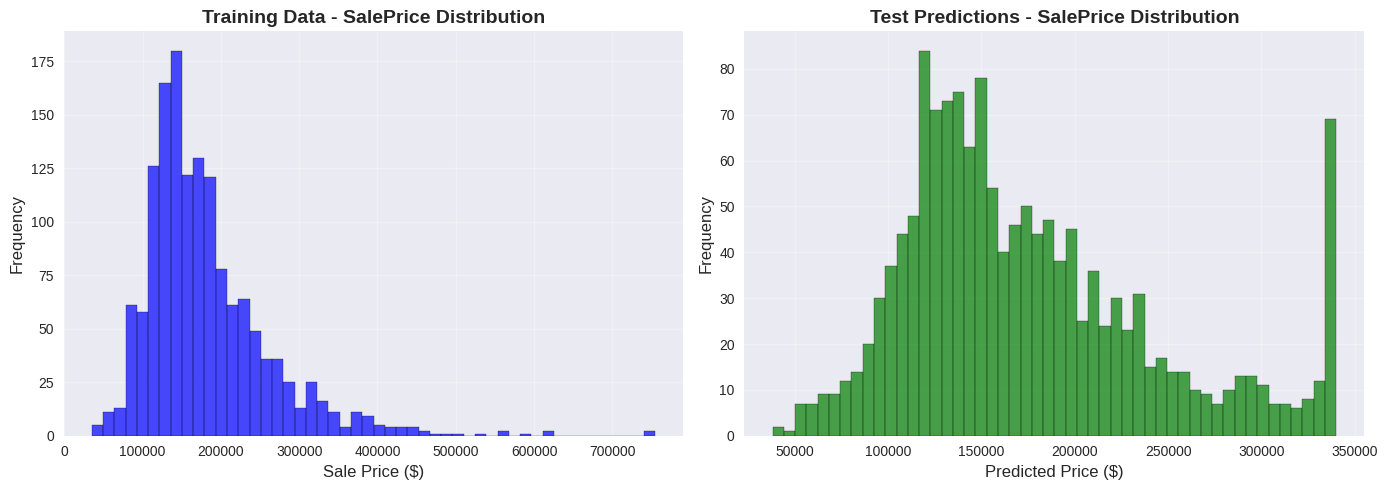

✓ Visualization complete


In [18]:
# Plot prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training data distribution
axes[0].hist(df_train['SalePrice'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Training Data - SalePrice Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sale Price ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(alpha=0.3)

# Test predictions distribution
axes[1].hist(test_predictions_clipped, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title('Test Predictions - SalePrice Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Price ($)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")